In [41]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')

%matplotlib inline

In [99]:
import math

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

def overlap_and_interpolate(seismic, pressure):
    ## Find overlap
    seismic_start = seismic.epoch.values[0]
    seismic_end = seismic.epoch.values[-1]
    
    pressure_start = pressure.epoch.values[0]
    pressure_end = pressure.epoch.values[-1]
    
    #start time
    t0 = max(seismic_start, pressure_start)
    #end time
    t1 = min(seismic_end, pressure_end)

    #convert epoch to days
    ep2day = 1. / 86400
    seismic['days'] = (seismic.epoch - t0) * ep2day
    pressure['days'] = (pressure.epoch - t0) * ep2day

    dt = (t1 - t0) * ep2day
    # bins = np.arange(0, math.ceil(dt) + 1)
    bins = np.arange(0,math.floor(dt)+1)

    seismic['t'] = np.digitize(
        seismic['days'], bins
    )

    # Interpolate pressure
    p_func = interp1d(
        pressure.days, pressure.pressure, 
        kind='linear'
    )
    dpdt_func = interp1d(
        pressure.days, pressure.dpdt, 
        kind='linear'
    )

    resampled_pressure_df = {}
    resampled_pressure_df['pressure'] = p_func(bins)
    resampled_pressure_df['dpdt'] = dpdt_func(bins)
    
    resampled_pressure_df = pd.DataFrame(resampled_pressure_df)

    return seismic, resampled_pressure_df, bins

def aggregate_seismic(seismic, n_steps, features, bin_name='days'):
    seismic_counts = seismic[[bin_name,'t']].groupby('t').agg('count')
    
    seismic_features = seismic[features].groupby('t').agg([np.mean, np.std]).fillna(0)
    seismic_features.columns = ['_'.join(col).strip() for col in seismic_features.columns.values]
    
    n_features = len(seismic_features.columns)
    
    output_vals = np.zeros((n_steps, n_features))
    output_vals[seismic_features.index.values] = seismic_features.values

    output_df = pd.DataFrame(output_vals, columns=seismic_features.columns)

    target_vals = np.zeros((n_steps,))
    target_vals[seismic_counts.index.values] = seismic_counts[bin_name].values
    
    return output_df, target_vals


def daily_seismic_and_interpolated_pressure(
        seismic, pressure, target_fn=np.cumsum
        #input_len=64, horizon=8, normalize_data=True, train_test_split=0.7
    ):
    #TODO: careful, overlap and interpolate does inplace modifications!
    _features = ['depth', 'easting', 'northing', 'magnitude', 't']
    seismic, pressure, bins = overlap_and_interpolate(seismic, pressure)
    seismic_features, target_vals = aggregate_seismic(seismic, len(bins)+1, _features, bin_name='days')
    target_vals = target_fn(target_vals)

    features = pd.concat([seismic_features, pressure], axis=1)
    features['seismic'] = target_vals

    return features, target_vals

In [109]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [110]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [111]:
input_len = 16
horizon = 7

In [112]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


IndexError: index 731 is out of bounds for axis 0 with size 731

In [113]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


IndexError: index 1110 is out of bounds for axis 0 with size 1110

In [89]:
pressure.head()

,epoch,pressure,dpdt,days
0,1.321564e+09,8.549666e+06,-0.001154,-27.497454
1,1.323528e+09,8.585858e+06,0.014734,-4.762275
2,1.325492e+09,8.648909e+06,0.027648,17.972904
3,1.327457e+09,8.682492e+06,0.012450,40.708083
4,1.329421e+09,8.699813e+06,0.006602,63.443262


In [30]:
import math

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

seismic_start = seismic.epoch.values[0]
seismic_end = seismic.epoch.values[-1]
    
pressure_start = pressure.epoch.values[0]
pressure_end = pressure.epoch.values[-1]
t0 = max(seismic_start, pressure_start)
t1 = min(seismic_end, pressure_end)

In [31]:
ep2day = 1. / 86400
seismic['days'] = (seismic.epoch - t0) * ep2day
pressure['days'] = (pressure.epoch - t0) * ep2day
dt = (t1 - t0) * ep2day
bins = np.arange(0, math.ceil(dt))
seismic['t'] = np.digitize(
    seismic['days'], bins
)
# seismic['days']
seismic['t']

p_func = interp1d(
    pressure.days, pressure.pressure, 
    kind='linear'
)
dpdt_func = interp1d(
    pressure.days, pressure.dpdt, 
    kind='linear'
)

resampled_pressure_df = {}
resampled_pressure_df['pressure'] = p_func(bins)
resampled_pressure_df['dpdt'] = dpdt_func(bins)
resampled_pressure_df = pd.DataFrame(resampled_pressure_df)

In [32]:
def overlap_and_interpolate(seismic, pressure):
    ## Find overlap
    seismic_start = seismic.epoch.values[0]
    seismic_end = seismic.epoch.values[-1]
    
    pressure_start = pressure.epoch.values[0]
    pressure_end = pressure.epoch.values[-1]
    
    #start time
    t0 = max(seismic_start, pressure_start)
    #end time
    t1 = min(seismic_end, pressure_end)

    #convert epoch to days
    ep2day = 1. / 86400
    seismic['days'] = (seismic.epoch - t0) * ep2day
    pressure['days'] = (pressure.epoch - t0) * ep2day

    dt = (t1 - t0) * ep2day
    # bins = np.arange(0, math.ceil(dt) + 1)
    bins = np.arange(0,math.floor(dt)+1)

    seismic['t'] = np.digitize(
        seismic['days'], bins
    )

    # Interpolate pressure
    p_func = interp1d(
        pressure.days, pressure.pressure, 
        kind='linear'
    )
    dpdt_func = interp1d(
        pressure.days, pressure.dpdt, 
        kind='linear'
    )

    resampled_pressure_df = {}
    resampled_pressure_df['pressure'] = p_func(bins)
    resampled_pressure_df['dpdt'] = dpdt_func(bins)
    
    resampled_pressure_df = pd.DataFrame(resampled_pressure_df)

    return seismic, resampled_pressure_df, bins

In [105]:
_features = ['depth', 'easting', 'northing', 'magnitude', 't']
seismic_out, pressure_out, bins_out = overlap_and_interpolate(seismic, pressure)
seismic_features, target_vals  = aggregate_seismic(seismic_out, len(bins)+1, _features, bin_name='days')
target_vals = np.cumsum(target_vals)
features = pd.concat([seismic_features, pressure], axis=1)
features['seismic'] = target_vals

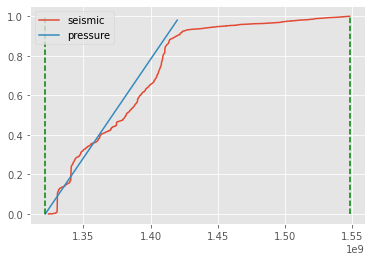

In [39]:
plt.plot(seismic.epoch, np.arange(len(seismic.epoch)) / len(seismic.epoch),label='seismic')
plt.plot(pressure.epoch, np.arange(len(pressure.epoch)) / len(pressure.epoch),label='pressure')
plt.legend()

plt.vlines(pressure.epoch[0], 0, 1, color='g', linestyle='--')
plt.vlines(seismic.epoch.values[-1], 0, 1, color='g', linestyle='--')

Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

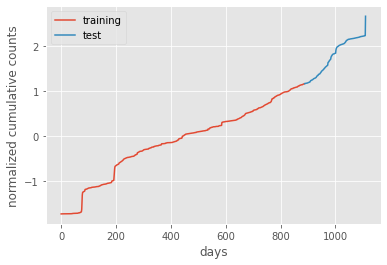

In [107]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    train_test_split=0.8, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

### Model Architecture

In [108]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [109]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
criterion = nn.MSELoss() # L2 loss
#criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [113]:
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [114]:

from tqdm.notebook import tqdm

In [115]:
torch.manual_seed(0)

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('HuberLoss')
plt.ylim([0,1])
plt.xlabel('Epoch')

Visualize the forecast

In [13]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]


In [14]:
def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

In [15]:
model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

In [16]:
samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

In [17]:
sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

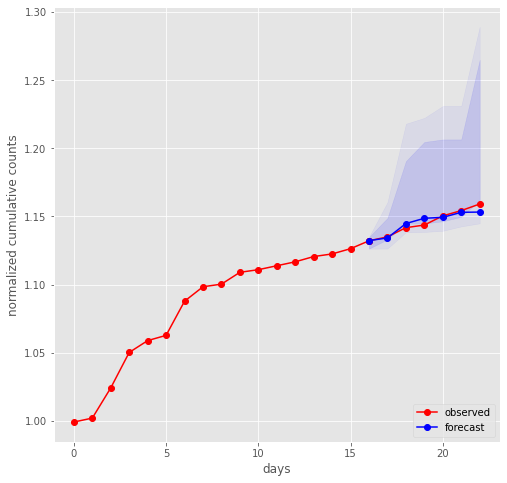

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()